# USA Airline Delay Cause Analysis

**By [Samuel Zhao](https://www.linkedin.com/in/samuel-zhao/)**

## Summary

Using the data of USA airline delay cause (data source: [Federal Aviation Administration](https://www.faa.gov/data_research)), I analyzed and visualized the number of arriving flights and delay minutes (in terms of different delay causes) from the perspective of time series, airline, and geographical location. Following are some important takeaways.

### Time Series Analysis
- From 2003 to 2017, the number of arriving flights goes down for the overall trend. It skyrockets since 2018 and peaks in 2019. The data plunges in 2020 expectedly. In 2022 the flight traffic goes back to the pre-pandemic level while still much lower than in 2019. On average, the number of arriving flights is highest in August and lowest in February. 

- From 2003 to 2022, the total delay minutes fluctuate severely, since the variance magnitude of delay minutes is much bigger than that of arriving flights. On average, the delay minutes reach the highest point in July and lowest in September.

- There is an asymmetry between the seasonality of the number of arriving flights and delay minutes. June and July are the peak months for severe thunderstorms. Therefore, delay minutes hit the peak during the period, though flight traffic does not peak until August.

### Delay Cause Analysis
- Delay cause of American Airlines and United Airlines are close to the benchmark.

- Delta Airlines' percentage of its 'carrier_delay' is much higher than the benchmark due to aged airplanes.

- Southwest Airlines’ percentage of its 'late_aircraft_delay' is much higher than the other three and the benchmark. According to my search, Southwest Airlines provides high-frequency flights for customers because of its supply chain strategy.

### Geographic Information Analysis
- California and Texas rank at the top regarding both the number of arriving flights and delay minutes due to their large population. Florida is climbing to a higher rank, as more people want to go to warm weather destinations.

### Austin Airport Performance Forecast
- Deloyed a **[dashboard](https://austin-ariport-delay-cause-dashboard.onrender.com)** to display Austin International Airport performance (including each airline's monthly delay minutes, delay cause, and delay minutes forecast)



## Preparation

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import plotly.express as px

In [55]:
import seaborn as sns

In [56]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [57]:
flight = pd.read_csv('Airline_Delay_Cause.csv')

## Data Processing

In [58]:
flight.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2022,11,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",86.0,2.0,0.00,0.74,...,0.0,0.00,0.0,0.0,54.0,0.0,26.0,28.0,0.0,0.0
1,2022,11,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",59.0,5.0,1.77,0.00,...,0.0,1.29,0.0,0.0,290.0,178.0,0.0,69.0,0.0,43.0
2,2022,11,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",21.0,1.0,0.01,0.00,...,0.0,0.99,0.0,0.0,118.0,1.0,0.0,0.0,0.0,117.0
3,2022,11,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",98.0,15.0,5.11,0.00,...,0.0,7.20,3.0,0.0,1270.0,334.0,0.0,62.0,0.0,874.0
4,2022,11,9E,Endeavor Air Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",1143.0,114.0,28.67,2.26,...,0.0,45.80,3.0,1.0,10874.0,5451.0,128.0,1071.0,0.0,4224.0


In [59]:
flight.dtypes

year                     int64
month                    int64
carrier                 object
carrier_name            object
airport                 object
airport_name            object
arr_flights            float64
arr_del15              float64
carrier_ct             float64
weather_ct             float64
nas_ct                 float64
security_ct            float64
late_aircraft_ct       float64
arr_cancelled          float64
arr_diverted           float64
arr_delay              float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
dtype: object

### Feature Information

- year: Year
- month: Month
- carrier: Carrier IATA code
- carrier_name: Carrier name
- airport: Airport IATA code
- airport_name: Airport name and location
- arr_flights: Number of arriving flights at certain airport
- arr_del15: Number of arriving flights that delay for 15 minutes
- carrier_ct: Delay minutes caused by air carrier
- weather_ct: Delay minutes caused by extreme weather
- nas_ct: Delay minutes caused by NAS
- security_ct: Delay minutes caused by security
- late_aircraft_ct: Delay minutes caused by late-arriving aircrafts
- arr_cancelled: Number of arriving flights cancelled
- arr_diverted: Number of arriving flights diverted
- arr_delay: Number of arriving flights that delay at certain airport
- carrier_delay: Delay minutes caused by air carrier
- weather_delay: Delay minutes caused by extreme weather
- nas_delay: Delay minutes caused by NAS
- security_delay: Delay minutes caused by security
- late_aircraft_delay: Delay minutes caused by late-arriving aircrafts

The airlines report the causes of delays in five broad categories:
- Air Carrier: The cause of the cancellation or delay was due to circumstances within the airline's control(e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.).
- Extreme Weather: Significant meteorological conditions (actual or forecasted) that, in the judgment of the carrier, delays or prevents the operation of a flight such as tornado, blizzard or hurricane.
- National Aviation System (NAS): Delays and cancellations attributable to the national refer to a broad set of conditions, such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control.
- Security: Delays or cancellations caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
- Late-arriving aircraft: A previous flight with same aircraft arrived late, causing the present flight to depart late.

### Missing Value

- Based on the return, the columns from ‘year’ through ‘airport_name’ has no missing value since they are all categorical data. However, for columns from ‘arr_flights’ through ‘late_aircraft_delay,’ they all have 491  missing values (except ‘arr_del15,’ which has 733 missing values).

- Since all those features could be zero, I replaced missing values on all columns with 0, which is reasonable and has no impact on the data frame.

In [60]:
flight.isnull().sum()

year                     0
month                    0
carrier                  0
carrier_name             0
airport                  0
airport_name             0
arr_flights            491
arr_del15              733
carrier_ct             491
weather_ct             491
nas_ct                 491
security_ct            491
late_aircraft_ct       491
arr_cancelled          491
arr_diverted           491
arr_delay              491
carrier_delay          491
weather_delay          491
nas_delay              491
security_delay         491
late_aircraft_delay    491
dtype: int64

In [61]:
flight.fillna(0,inplace=True)

In [62]:
flight.isnull().sum()

year                   0
month                  0
carrier                0
carrier_name           0
airport                0
airport_name           0
arr_flights            0
arr_del15              0
carrier_ct             0
weather_ct             0
nas_ct                 0
security_ct            0
late_aircraft_ct       0
arr_cancelled          0
arr_diverted           0
arr_delay              0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
dtype: int64

### Merge Year and Month

From this, I am taking a few steps to tweak the dataset to facilitate the data analysis afterward. 

- First, I merged the 'year' and 'month' columns and created a new column, 'date,' which will be used to analyze time-series data and be selected as an x-axis.

In [63]:
flight['date']=pd.to_datetime(flight[['year','month']].assign(DAY=1))

<h3>Delimit Geo Information</h3>

In addition, because I want to analyze the by-state performance of flights, I have to extract geographic information from column ‘airport_name,’ which combines city, state, and airport information. 

- So, first, I delimited the ‘airport_name’ column and then created new columns, ‘city’ and ‘state,’ meanwhile replacing the original ‘airport_name’ with only airport name information. 

- Here I found that all cells of ‘state’ and ‘airport_name’ include a space before text. Therefore, I remove all of spaces in the two columns.

In [64]:
flight[['city','state','airport_name']]=flight['airport_name'].str.split(',|:',expand=True)

In [65]:
flight['state'] = flight['state'].str.replace(" ","")

In [66]:
flight['airport_name'] = flight['airport_name'].str[1:]

## Exploratory Data Analysis

### Data Distribution

- For ‘arr_flights,’ the summary information of its distribution is displayed below. Through the histogram, we can see that most of the values fall in the range between 1 and 55.

- For ‘arr_delay,’ I also used ‘.decribe()’ to observe its basic information. The histogram below shows that most values are between 0 and 308.

In [67]:
flight["arr_flights"].describe()

count    328207.000000
mean        379.819373
std        1024.042306
min           0.000000
25%          58.000000
50%         120.000000
75%         271.000000
max       21977.000000
Name: arr_flights, dtype: float64

(array([33334., 41200., 42509., 34506., 26059., 21179., 16253., 12933.,
         9905.,  8361.]),
 array([  1. ,  28.2,  55.4,  82.6, 109.8, 137. , 164.2, 191.4, 218.6,
        245.8, 273. ]),
 <BarContainer object of 10 artists>)

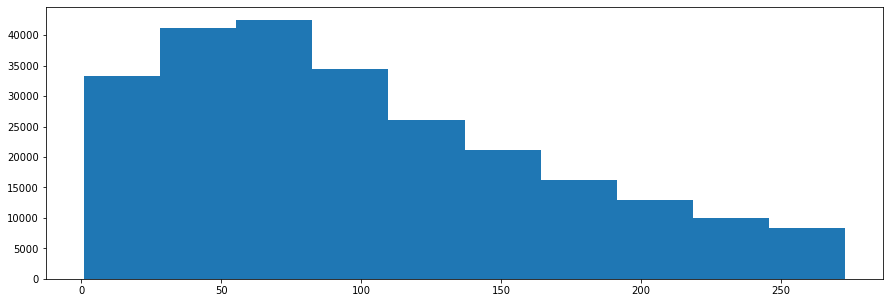

In [68]:
plt.figure(figsize=(15,5))
plt.hist(flight["arr_flights"],range=[1,273])

In [69]:
flight["arr_delay"].describe()

count    328207.000000
mean       4211.526235
std       12536.806598
min           0.000000
25%         430.000000
50%        1193.000000
75%        3071.000000
max      433687.000000
Name: arr_delay, dtype: float64

(array([63343., 43671., 33759., 26309., 20895., 16551., 13441., 11150.,
         9387.,  7888.]),
 array([   0.,  308.,  616.,  924., 1232., 1540., 1848., 2156., 2464.,
        2772., 3080.]),
 <BarContainer object of 10 artists>)

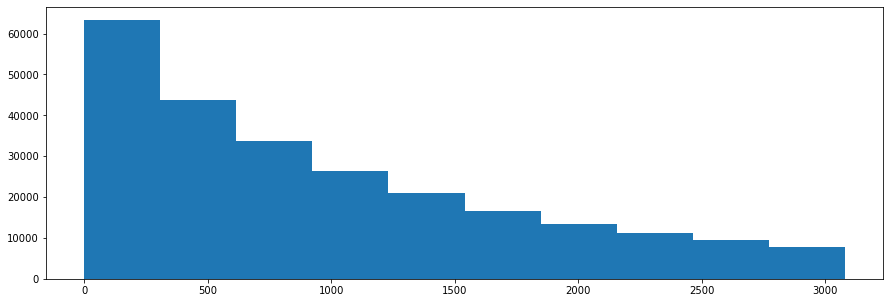

In [70]:
plt.figure(figsize=(15,5))
plt.hist(flight["arr_delay"],range=[0,3080])

## Time Series Analysis

- I plotted the total number of arriving flights in the USA from 2003 through 2022. During the whole period, the total number of arriving flights peak in July 2021 (659,029), and its lowest point is May 2020 (180,617). 

- We can see the trend of the data over time. From 2003 to 2017, the number of arriving flights goes down for the overall trend. It skyrockets since 2018 and peaks in 2019, during the time of President Trump (I am not sure if it is related to his policies). 

- 2020 is the first year of the COVID pandemic, and the data plunges expectedly. Luckily, in 2022 the flight traffic goes back to the pre-pandemic level while still much lower than in 2019.

- Seasonal change is evident in the plot from year to year. 

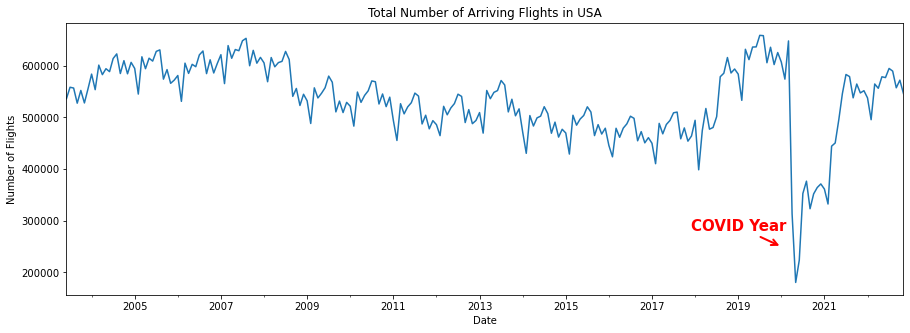

In [71]:
plt.figure(figsize=(15,5))
flight.groupby(['date'])['arr_flights'].sum().plot()
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.title('Total Number of Arriving Flights in USA')
plt.annotate('COVID Year',
             xy=('2020',250000),
             xytext=('2019',280000),
             arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', linewidth=2),
             fontsize=15,
             fontweight='bold',
             color='red',
             horizontalalignment='center')
plt.show()

In [72]:
flight.groupby(['date'])['arr_flights'].sum().describe()

count       234.000000
mean     532732.380342
std       73783.336713
min      180617.000000
25%      490402.000000
50%      538716.500000
75%      585649.500000
max      659029.000000
Name: arr_flights, dtype: float64

In [73]:
flight.groupby(['date'])['arr_flights'].sum().sort_values(ascending=True)

date
2020-05-01    180617.0
2020-06-01    223732.0
2020-04-01    313382.0
2020-09-01    323347.0
2021-02-01    332468.0
                ...   
2020-03-01    648229.0
2007-07-01    648560.0
2007-08-01    653279.0
2019-08-01    658461.0
2019-07-01    659029.0
Name: arr_flights, Length: 234, dtype: float64

- I plotted the average monthly total number of arriving flights over years. 2020 is excluded in the calculation since the year is severely influenced by COVID and brings innegligible noise to seasonality analysis.

- On average, the number of arriving flights is highest in August and lowest in February. Flight traffic goes up overall from February to August and decreases gradually from September to January next year.

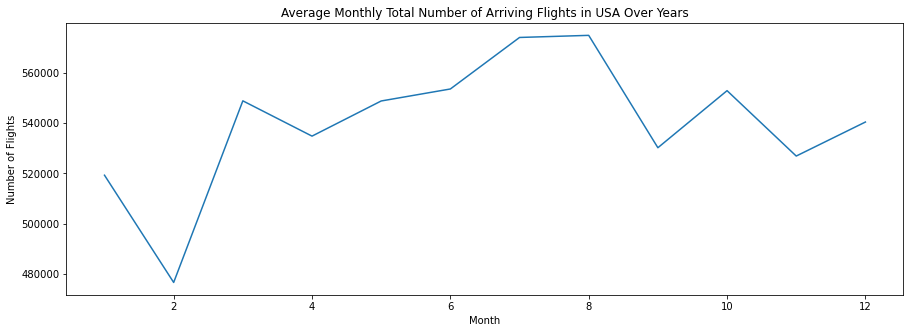

In [74]:
plt.figure(figsize=(15,5))
#exlcude year 2020 here due to COVID's influence
flight[flight['year']!=2020].groupby(['month','year'])['arr_flights'].sum().groupby(['month']).mean().plot()
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.title('Average Monthly Total Number of Arriving Flights in USA Over Years')
plt.show()

- Next, I plotted the total flight delay minutes in the USA from 2003 to 2022. During the whole period, the total delay minutes peak in June 2007 (11,431,169), and its lowest point is May 2020 (482,701). 

- The total delay minutes fluctuate severely, seemingly with no trend and seasonality. Nevertheless, I evaluated the data (excluding 2020) with the ADF test, and the p-value (0.154, which is less than 0.05) indicates that it's a strongly non-stationary dataset. 

- Furthermore, the variance magnitude of delay minutes is much bigger than that of arriving flights regarding their standard deviations.

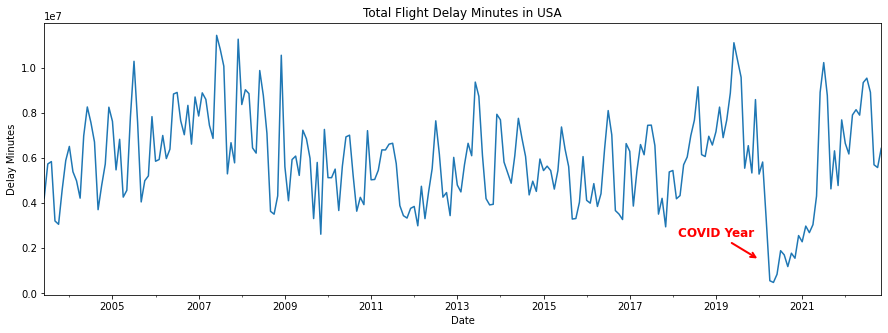

<Figure size 432x288 with 0 Axes>

In [128]:
plt.figure(figsize=(15,5))
flight.groupby(['date'])['arr_delay'].sum().plot()
plt.xlabel('Date')
plt.ylabel('Delay Minutes')
plt.title('Total Flight Delay Minutes in USA')
plt.annotate('COVID Year',
             xy=('2020', 1500000),
             xytext=('2019',2500000),
             arrowprops=dict(facecolor='red', edgecolor='red', linewidth=2, arrowstyle='->'),
             fontsize=12,
             fontweight='bold',
             color='red',
             horizontalalignment='center')
plt.show()
plt.savefig('delay minutes time line.png', bbox_inches='tight')

In [76]:
flight.groupby(['date'])['arr_delay'].sum().describe()

count    2.340000e+02
mean     5.907062e+06
std      2.097094e+06
min      4.827010e+05
25%      4.338634e+06
50%      5.845668e+06
75%      7.197195e+06
max      1.143117e+07
Name: arr_delay, dtype: float64

In [77]:
flight.groupby(['date'])['arr_delay'].sum().sort_values(ascending=True)

date
2020-05-01      482701.0
2020-04-01      558077.0
2020-06-01      843800.0
2020-09-01     1185386.0
2020-11-01     1555140.0
                 ...    
2008-12-01    10549666.0
2007-07-01    10815811.0
2019-06-01    11103884.0
2007-12-01    11261442.0
2007-06-01    11431169.0
Name: arr_delay, Length: 234, dtype: float64

In [78]:
from statsmodels.tsa.stattools import adfuller
adfuller(flight[flight['year']!=2020].groupby(['date'])['arr_delay'].sum())
#ADF test, p-value is less than 0.05, data is non-stationary

(-2.3568874148273022,
 0.15427602445798372,
 13,
 208,
 {'1%': -3.4621857592784546,
  '5%': -2.875537986778846,
  '10%': -2.574231080806213},
 6399.646098077889)

- Then, I plotted the average monthly total delay minutes over the years (excluding 2020). On average, the delay minutes reach the highest point in July and lowest in September. 

- But, to my surprise, the seasonal change of delay minutes is not in line with the number of arriving flights. Therefore, I will try to figure it out in the following part.

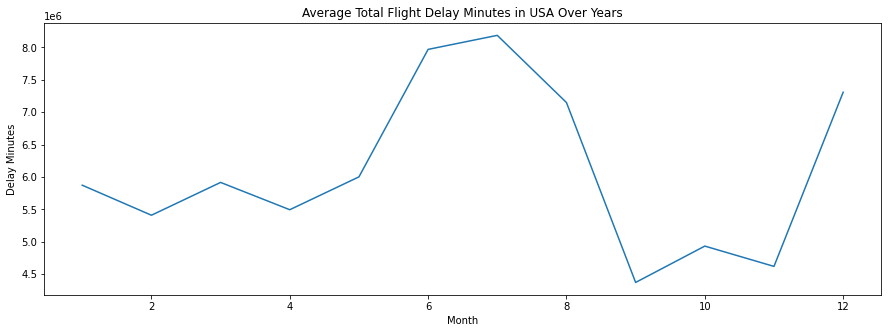

In [79]:
plt.figure(figsize=(15,5))
flight[flight['year']!=2020].groupby(['month','year'])['arr_delay'].sum().groupby(['month']).mean().plot()
#exlcude year 2020 here due to COVID's influence
plt.xlabel('Month')
plt.ylabel('Delay Minutes')
plt.title('Average Total Flight Delay Minutes in USA Over Years')
plt.show()

## Delay Cause Analysis

- I plotted the delay minutes of different delay causes. We can see that 'weather_delay' and 'security delay' are at the bottom, above which the other three lines intertwine. 

- 'Late_aircraft_delay' is usually on top, which accounts for most of the delay minutes. 'Nas_delay' and 'carrier_delay' are almost on the same level.

/var/folders/79/wn0l4g7119l_cnl729l6kr6w0000gn/T/ipykernel_98907/2314639755.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



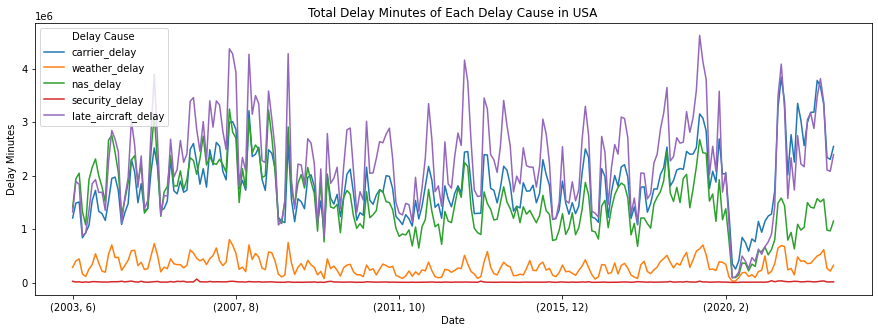

<Figure size 432x288 with 0 Axes>

In [127]:
flight.groupby(['year','month'])['carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay'].sum().plot(figsize=(15,5))
plt.legend(title='Delay Cause')
plt.xlabel('Date')
plt.ylabel('Delay Minutes')
plt.title('Total Delay Minutes of Each Delay Cause in USA')
plt.show()

- Then, I made a plot to display that each delay cause contributes to how much percentage of total delay minutes in each month. Aligned with what we observed previously, 'late_aircraft_delay' generate the most delay minutes every month. 

Here we can explain the asymmetry between the seasonality of the number of arriving flights and delay minutes. 
- In June, both 'carrier_delay' and 'weather_delay' percentage increase, while 'nas_delay' and 'carrier_delay' decrease.
- According to meteorological records, June and July in particular are the peak months for severe thunderstorms with high winds. Therefore, delay minutes hit the peak during the period, though flight traffic does not reach the highest point until August. 
- In August, the percentages of 'carrier_delay' and 'nas_delay' jump up, which may be attributed to high flights this month.

/var/folders/79/wn0l4g7119l_cnl729l6kr6w0000gn/T/ipykernel_98907/1752273150.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Text(0.5, 1.0, 'Average Monthly Delay Cause Minute% in USA Over Years')

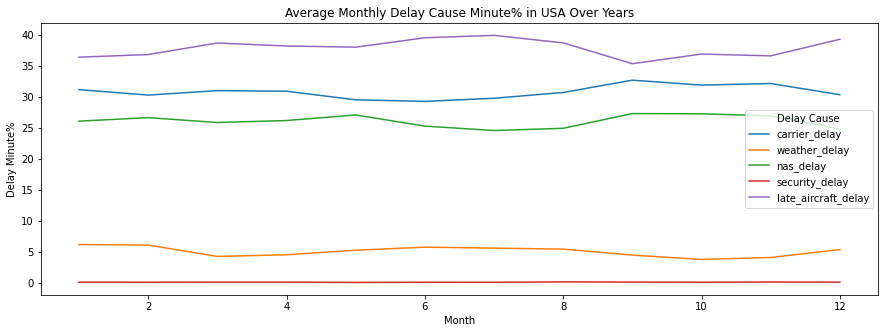

In [81]:
flight[flight['year']!=2020].groupby(['month','year'])['carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay'].sum().groupby(['month']).agg('mean').apply(lambda x:round(x/x.sum()*100,2), axis=1).plot(kind='line',figsize=(15,5))
plt.legend(title='Delay Cause')
plt.xlabel('Month')
plt.ylabel('Delay Minute%')
plt.title('Average Monthly Delay Cause Minute% in USA Over Years')

Next part, let's look at the delay cause of each airline. 

- First of all, I created a pie chart to display the delay cause of all USA airlines, which can be seen as a benchmark.For example, 36.5% of delay minutes belong to 'Late_aircraft_delay.' In contrast, 'security_delay' only accounts for less than 0.2%. 

In [82]:
airline_delay_cause=flight[flight['year']!=2020].groupby(['year','carrier_name'])['carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay'].sum().groupby(['carrier_name']).mean().T.reset_index()
airline_delay_cause.rename(columns={'index':'delay_cause'},inplace=True)
airline_delay_cause = airline_delay_cause.set_index('delay_cause')
airline_delay_cause['total']=airline_delay_cause.sum(axis=1)

/var/folders/79/wn0l4g7119l_cnl729l6kr6w0000gn/T/ipykernel_98907/3103124788.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [83]:
airline_delay_cause

carrier_name,ATA Airlines d/b/a ATA,AirTran Airways Corporation,Alaska Airlines Inc.,Allegiant Air,Aloha Airlines Inc.,America West Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Coast Airlines,Atlantic Southeast Airlines,...,PSA Airlines Inc.,Pinnacle Airlines Inc.,Republic Airline,SkyWest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,total
delay_cause,,,,,,,,,,,,,,,,,,,,,
carrier_delay,101376.00,3.615922e+05,468286.842105,628509.25,48307.333333,566482.666667,2.748049e+06,1.418292e+06,532000.5,1.537507e+06,...,716935.00,873032.2,896844.75,2.402084e+06,2.963427e+06,5.550641e+05,1.054174e+06,1.623988e+06,119627.714286,3.235775e+07
weather_delay,5784.00,2.798317e+04,41145.000000,119955.75,765.666667,23904.333333,5.072440e+05,3.757650e+05,158638.5,4.798569e+05,...,170072.00,133948.4,179858.75,4.113998e+05,3.893841e+05,8.087586e+04,1.136862e+05,2.446668e+05,35071.857143,6.114340e+06
nas_delay,217992.00,7.345010e+05,380913.526316,321797.00,5311.000000,441363.666667,2.205175e+06,1.477020e+06,758870.0,1.027648e+06,...,414367.75,661666.2,1093516.00,1.274734e+06,1.579955e+06,1.107128e+06,1.312294e+06,1.790534e+06,300222.428571,2.902604e+07
security_delay,3227.50,0.000000e+00,7941.578947,7259.00,623.666667,8089.333333,1.382537e+04,2.475833e+03,1578.0,4.418222e+03,...,4634.50,2135.4,3403.00,1.107563e+04,2.790179e+04,1.264671e+04,8.570385e+03,2.346579e+03,2662.714286,1.881176e+05
late_aircraft_delay,182408.25,1.151756e+06,533288.631579,827931.75,32466.000000,388208.000000,3.113627e+06,2.095214e+06,1000498.0,9.928228e+05,...,1215934.75,849047.4,1234428.75,2.552539e+06,5.743697e+06,6.883239e+05,1.227319e+06,2.462582e+06,241775.857143,3.893291e+07


In [84]:
pie_labels = ['Carrier Delay', ' Weather Delay', 'NAS Delay', 'Security Delay', 'Late Aircraft Delay']

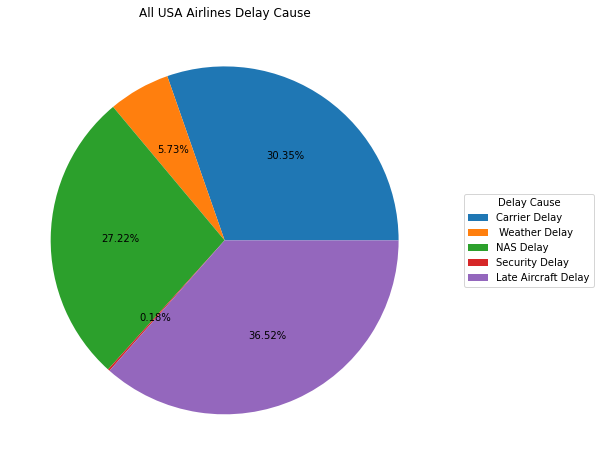

In [85]:
airline_delay_cause['total'].plot(kind='pie', autopct='%1.2f%%',figsize=(15,8),labeldistance=None)
plt.legend(pie_labels, title='Delay Cause', loc='center', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('')
plt.title('All USA Airlines Delay Cause')
plt.show()

The table shows the percentage of each delay cause, including all airlines in the USA. Meanwhile, the maximum values in each column are highlighted in yellow.

In [86]:
airline_delay_cause.apply(lambda x: round(x/x.sum()*100,2),axis=0).T.style.highlight_max(color='yellow')

delay_cause,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
carrier_name,,,,,
ATA Airlines d/b/a ATA,19.850000,1.130000,42.680000,0.630000,35.710000
AirTran Airways Corporation,15.890000,1.230000,32.270000,0.000000,50.610000
Alaska Airlines Inc.,32.710000,2.870000,26.610000,0.550000,37.250000
Allegiant Air,32.980000,6.300000,16.890000,0.380000,43.450000
Aloha Airlines Inc.,55.230000,0.880000,6.070000,0.710000,37.120000
America West Airlines Inc.,39.670000,1.670000,30.910000,0.570000,27.180000
American Airlines Inc.,32.000000,5.910000,25.680000,0.160000,36.260000
American Eagle Airlines Inc.,26.420000,7.000000,27.510000,0.050000,39.030000
Atlantic Coast Airlines,21.700000,6.470000,30.950000,0.060000,40.810000


I selected four airlines, United Airlines, American Airlines, Delta Airlines, and Southwest Airlines, and compared them with benchmark performance. 

- The stacked bar chart shows us that the contributions of delay cause of American Airlines and United Airlines are close to the benchmark. 

- Delta Airlines' percentage of its 'carrier_delay' is much higher than the benchmark because Delta owns many aged airplanes, which prolongs the operation time and causes delays. 

- As for Southwest Airlines, the percentage of its 'late_aircraft_delay' is much higher than the other three and the benchmark. According to my search, Southwest Airlines provides high-frequency flights for customers, so flights are usually back-to-back due to its supply chain strategy. Consequently, a delayed flight has a rippling effect on all subsequent flights.

In [87]:
airline_delay_cause[['total','United Air Lines Inc.','American Airlines Inc.','Delta Air Lines Inc.','Southwest Airlines Co.']].apply(lambda x:round(x/x.sum()*100,2), axis=0).T

delay_cause,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
carrier_name,,,,,
total,30.35,5.73,27.22,0.18,36.52
United Air Lines Inc.,26.52,4.00,29.24,0.04,40.21
American Airlines Inc.,32.00,5.91,25.68,0.16,36.26
Delta Air Lines Inc.,36.03,5.29,29.37,0.10,29.22
Southwest Airlines Co.,27.68,3.64,14.76,0.26,53.66


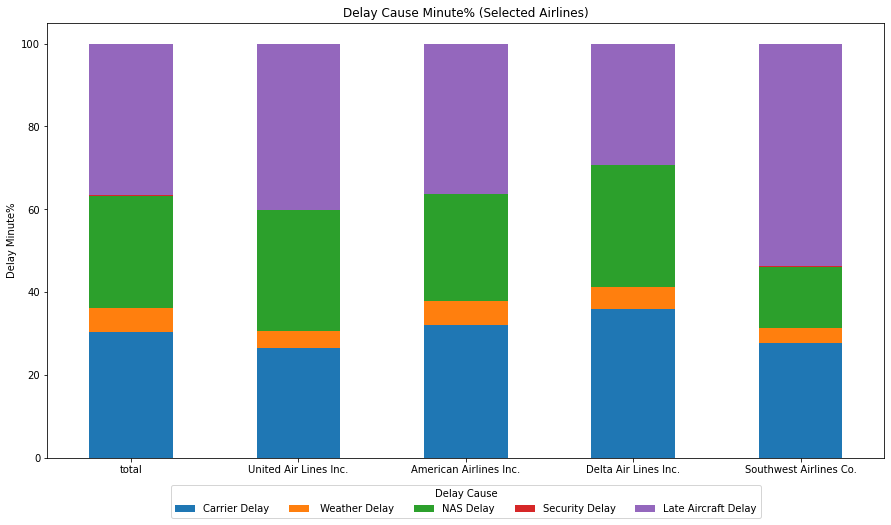

In [88]:
airline_delay_cause[['total','United Air Lines Inc.','American Airlines Inc.','Delta Air Lines Inc.','Southwest Airlines Co.']].apply(lambda x:x/x.sum()*100).T.plot(kind='bar',stacked=True,figsize=(15,8))
plt.xticks(rotation=0)
plt.legend(pie_labels, title='Delay Cause', loc='center', bbox_to_anchor=(0.5,-0.1),ncol=5)
plt.xlabel('')
plt.ylabel('Delay Minute%')
plt.title('Delay Cause Minute% (Selected Airlines)')
plt.show()

## Geographic Information Analysis

For the last part, let's look at each state's data. 

- First, I plotted and colored the number of arriving flights on the U.S. map. Then, we can drag the slider to see each year's performance (2003-2022). The darker color represents a higher number of arriving flights. 

- Overall, California and Texas are the darkest areas on the graph. Northwest and mid-west regions have relatively low flight volumes. In contrast, east coast states have higher flight volumes. 

- From the first to the last year, California and Texas consistently rank the top due to the high population in the two states. Meanwhile, Florida gradually ranks higher over time, as more people want to go to warm weather destinations.

In [89]:
state_arr_flights=flight.groupby(['year','state'], as_index=False)['arr_flights'].sum()

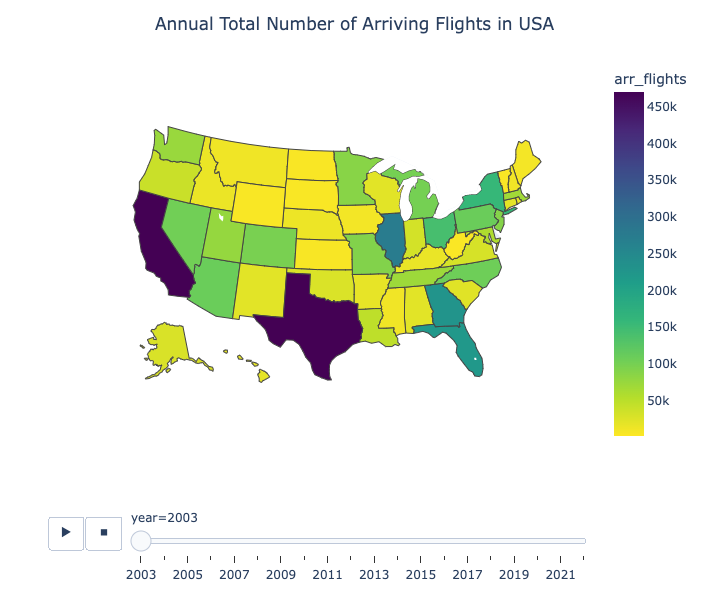

In [126]:
fig1 = px.choropleth(state_arr_flights,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='arr_flights',
                    color_continuous_scale="viridis_r", 
                    animation_frame='year')

fig1.update_layout(width=700, height=600, 
                   title=dict(text='Annual Total Number of Arriving Flights in USA',x=0.5)
                  )
fig1.show()

In [91]:
state_arr_delay=flight.groupby(['year','state'], as_index=False)['arr_delay'].sum()

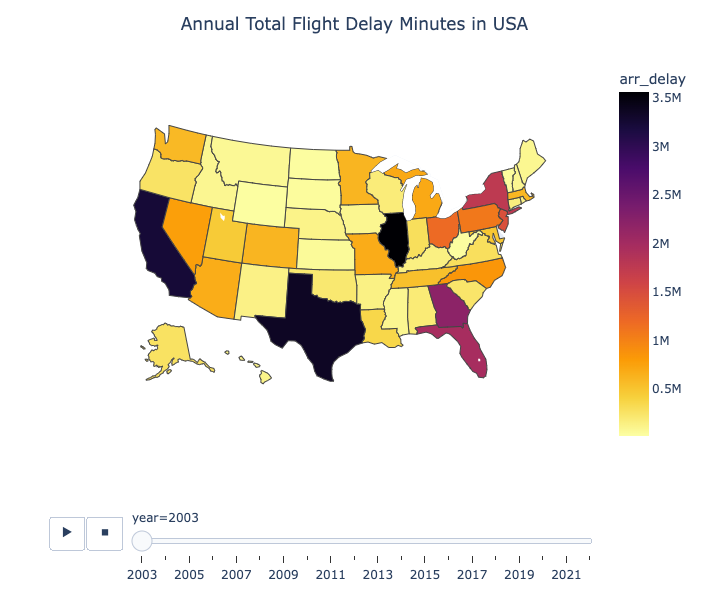

In [129]:
fig2 = px.choropleth(state_arr_delay,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='arr_delay',
                    color_continuous_scale="inferno_r", 
                    animation_frame='year')

fig2.update_layout(width=700, height=600,
                  title=dict(text='Annual Total Flight Delay Minutes in USA', x=0.5)
                  )
fig2.show()

## Austin Airport Performance Forecast

- In this part, I used Holt Winters model (based on trend and seasonality) and forecasted Austin airport performance (number of arriving flights and delay minutes) in 2023.

- I used plotly.dash to create and deploy the performance [report](https://austin-ariport-delay-cause-dashboard.onrender.com) (click to see the dashboard).

In [93]:
flight.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,date,city,state
0,2022,11,9E,Endeavor Air Inc.,ABY,Southwest Georgia Regional,86.0,2.0,0.00,0.74,...,0.0,54.0,0.0,26.0,28.0,0.0,0.0,2022-11-01,Albany,GA
1,2022,11,9E,Endeavor Air Inc.,AEX,Alexandria International,59.0,5.0,1.77,0.00,...,0.0,290.0,178.0,0.0,69.0,0.0,43.0,2022-11-01,Alexandria,LA
2,2022,11,9E,Endeavor Air Inc.,AGS,Augusta Regional at Bush Field,21.0,1.0,0.01,0.00,...,0.0,118.0,1.0,0.0,0.0,0.0,117.0,2022-11-01,Augusta,GA
3,2022,11,9E,Endeavor Air Inc.,ALB,Albany International,98.0,15.0,5.11,0.00,...,0.0,1270.0,334.0,0.0,62.0,0.0,874.0,2022-11-01,Albany,NY
4,2022,11,9E,Endeavor Air Inc.,ATL,Hartsfield-Jackson Atlanta International,1143.0,114.0,28.67,2.26,...,1.0,10874.0,5451.0,128.0,1071.0,0.0,4224.0,2022-11-01,Atlanta,GA


In [94]:
austin = flight[flight['airport_name']=='Austin - Bergstrom International']

In [95]:
austin_delay = austin.groupby(['date'])['arr_delay'].sum().resample('M').mean()

In [96]:
delay_train = austin_delay.loc[:'2022']

In [97]:
delay_model = ExponentialSmoothing(delay_train, seasonal_periods=12, trend='add', seasonal='add')
delay_fit = delay_model.fit()

/Users/zhaochongxin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [98]:
delay_forecast = delay_fit.forecast(12)

In [99]:
delay_data = pd.concat([delay_train, delay_forecast], axis=1)
delay_data = delay_data.rename(columns={'arr_delay':'actual', 0:'forecast'})

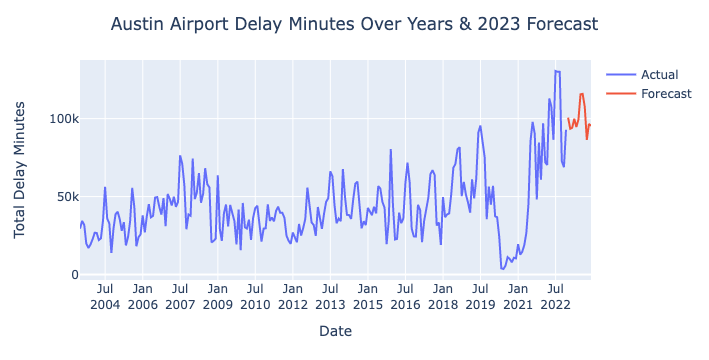

In [112]:
fig = px.line()
fig.add_scatter(x=delay_data.index, y=delay_data['actual'], mode='lines', name='Actual')
fig.add_scatter(x=delay_data.index, y=delay_data['forecast'], mode='lines', name='Forecast')
fig.update_layout(title=dict(text='Austin Airport Delay Minutes Over Years & 2023 Forecast', 
                             x=0.5),
                  xaxis=dict(title='Date',
                         tickmode='linear',
                         dtick='M18',
                         tickformat='%b\n%Y'),
                  yaxis_title='Total Delay Minutes')
fig.show()

In [101]:
austin_flights = austin.groupby(['date'])['arr_flights'].sum().resample('M').mean()

In [102]:
flights_train = austin_flights.loc[:'2022']

In [103]:
flights_model = ExponentialSmoothing(flights_train, seasonal_periods=12, trend='add', seasonal='add')
flights_fit = flights_model.fit()

In [104]:
flights_forecast = flights_fit.forecast(12)

In [105]:
flights_data = pd.concat([flights_train, flights_forecast], axis=1)
flights_data = flights_data.rename(columns={'arr_flights':'actual', 0:'forecast'})

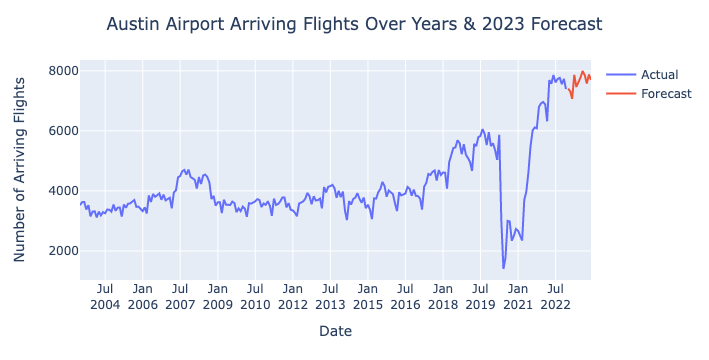

In [113]:
fig2 = px.line()
fig2.add_scatter(x=flights_data.index, y=flights_data['actual'], mode='lines', name='Actual')
fig2.add_scatter(x=flights_data.index, y=flights_data['forecast'], mode='lines', name='Forecast')
fig2.update_layout(title=dict(text='Austin Airport Arriving Flights Over Years & 2023 Forecast',
                              x=0.5),
                   yaxis_title='Number of Arriving Flights',
                   xaxis=dict(title='Date',
                              dtick='M18',
                              tickformat='%b\n%Y'))